In [35]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import ast
import sys
import importlib
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskElasticNet
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, KFold
import pickle

In [36]:
pd.set_option('display.max_columns', None)

In [37]:
# Append the project root directory to sys.path
sys.path.append(os.path.join(os.getcwd(), '..'))

from config import config

# import the root directory path
project_path = config.ROOT_DIR
print("Project Path:", project_path)

Project Path: C:\Users\chame\OneDrive\Desktop\Test_Env_Data_Analysis\For_Porfolio\House Prices - Advanced Regression\house-prices-advanced-regression-techniques


#### Import functions

In [38]:
sys.path.append(project_path+"/scripts/data_prep/")

In [59]:
import prep
import transformation
import file_mngt
importlib.reload(prep)
importlib.reload(transformation)
importlib.reload(file_mngt)

<module 'file_mngt' from 'C:\\Users\\chame\\OneDrive\\Desktop\\Test_Env_Data_Analysis\\For_Porfolio\\House Prices - Advanced Regression\\house-prices-advanced-regression-techniques/scripts/data_prep\\file_mngt.py'>

In [60]:
from prep import fill_na, column_overview, determine_cardinality
from file_mngt import save_list_to_file
from transformation import plot_and_transform_skewness_all_cols, plot_and_transform_skewness_specific_cols
from transformation import plot_square_root_transformation, scale_numerical_features, one_hot_encode_dataframe, separate_variables_for_model_dev
from transformation import separate_variables_for_model_dev

### 1. Import Data

In [41]:
df_test = pd.read_csv(project_path+"/data/test.csv")

In [42]:
total_num_observations=df_test.shape[0]

In [43]:
# import feature lists
with open(project_path+"/data/feature_selection/manually_removed_features.txt", "r") as f:
    mrf = f.read()

manually_removed_features_list = ast.literal_eval(mrf)

with open(project_path+"/data/feature_selection/features_for_square_root_transformation.txt", "r") as f:
    fsrt = f.read()

features_for_square_root_transformation_list = ast.literal_eval(fsrt)

with open(project_path+"/data/feature_selection/features_to_exclude_from_log_exp_transformation.txt", "r") as f:
    exl_transformation = f.read()

features_to_exclude_from_log_exp_transformation = ast.literal_eval(exl_transformation)

In [44]:
with open(project_path+"/data/feature_selection/Lasso_Features.txt", "r") as f:
    LF = f.read()

Lasso_Features_list = ast.literal_eval(LF)

with open(project_path+"/data/feature_selection/Ridge_Features.txt", "r") as f:
    RF = f.read()

Ridge_Features_list = ast.literal_eval(RF)

with open(project_path+"/data/feature_selection/XGBR_Features.txt", "r") as f:
    xgbr_f = f.read()

XGBR_Features_list = ast.literal_eval(xgbr_f)

### 2. Data Cleaning and Transformation

#### Manage Null Values

In [45]:
# Generate a dataframe that identifies features with high null values
null_list=[]
for col in list(df_test.columns):
    num_null = df_test[df_test[col].isna()].shape[0]
    perc = round(((num_null/total_num_observations)*100),1)
    null_list.append([col, num_null, perc])

null_df = pd.DataFrame(null_list, columns=["Feature", "Null Count", "Null Percentage"])

In [46]:
null_df.sort_values('Null Percentage', ascending=False).head(20)

,Feature,Null Count,Null Percentage
72,PoolQC,1456,99.8
74,MiscFeature,1408,96.5
6,Alley,1352,92.7
73,Fence,1169,80.1
25,MasVnrType,894,61.3
57,FireplaceQu,730,50.0
3,LotFrontage,227,15.6
64,GarageCond,78,5.3
59,GarageYrBlt,78,5.3
60,GarageFinish,78,5.3


In [47]:
# fill NaN values in accordance with the training dataset
df_test = fill_na(df_test)

In [48]:
# Confirming there are no null features
df_test.isna().sum()[df_test.isna().sum()>0]

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
SaleType        1
dtype: int64

##### The best course of action would be to review the data description file to identify the values to fill NaN values. However, given the low number of NaN values for this project these observations will be removed from the process.

In [49]:
# Identify and remove all rows where NaN values are present
features_to_remove = df_test.isna().sum()[df_test.isna().sum()>0].index
print(f"Percentage of observations removed from the test df: {round(((df_test[df_test[features_to_remove].isna().any(axis=1)].shape[0]/total_num_observations)*100),3)}%")

df_test = df_test[~df_test[features_to_remove].isna().any(axis=1)]

Percentage of observations removed from the test df: 0.822%


In [50]:
# Confirming there are no null features
df_test.isna().sum()[df_test.isna().sum()>0]

Series([], dtype: int64)

#### Manual Feature Selection

In [51]:
# Manually selected features to be removed due to being deemed not relevant for the model
df_test.drop(columns=manually_removed_features_list, inplace=True)

#### Log / Exponential Transformations

In [52]:
# Create numerical dataframe
numerical_df = df_test[list(df_test.dtypes[df_test.dtypes!="object"].index)]

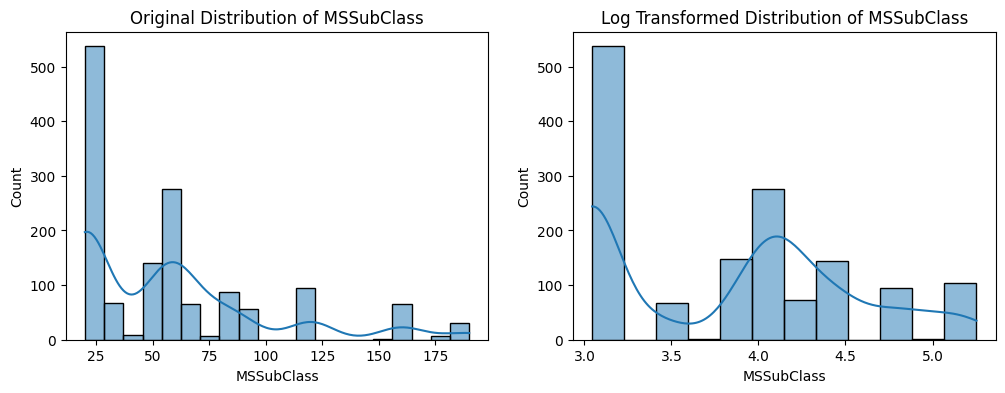

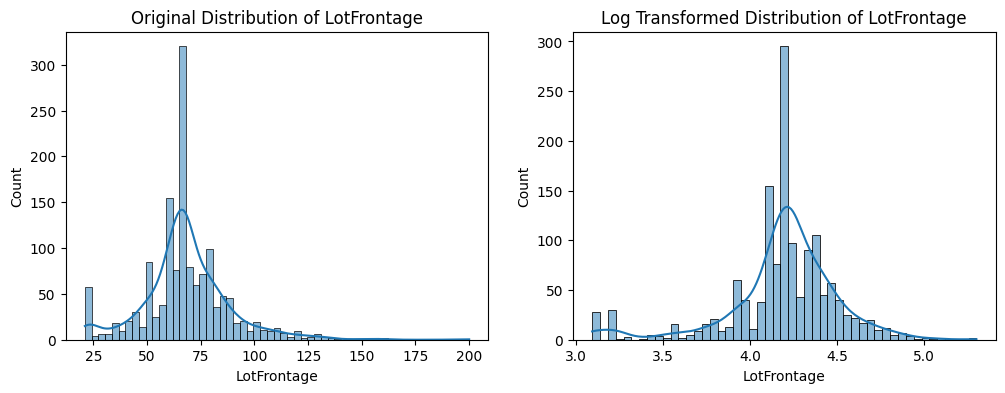

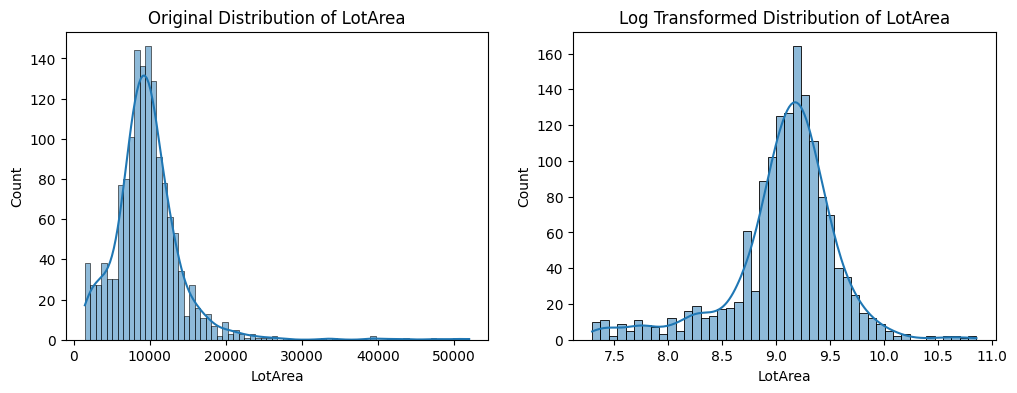

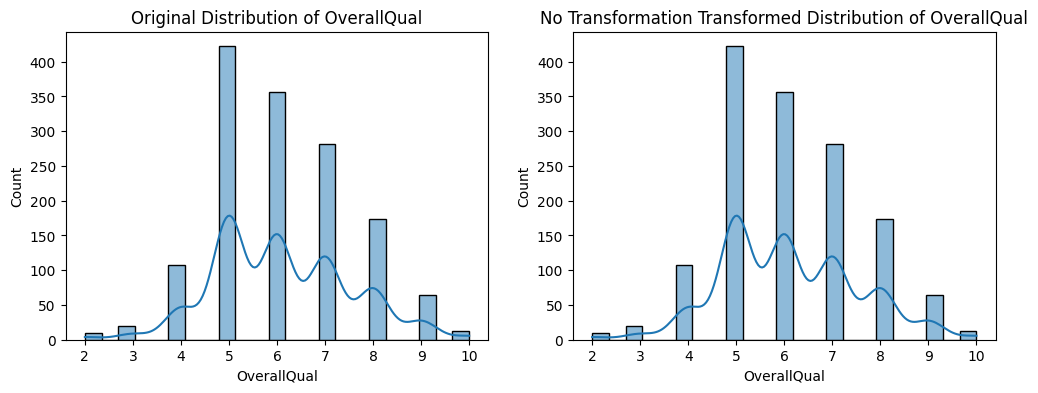

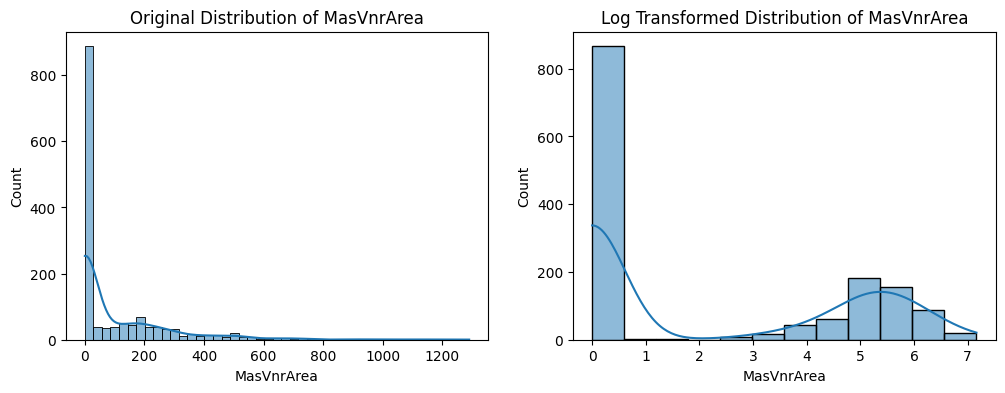

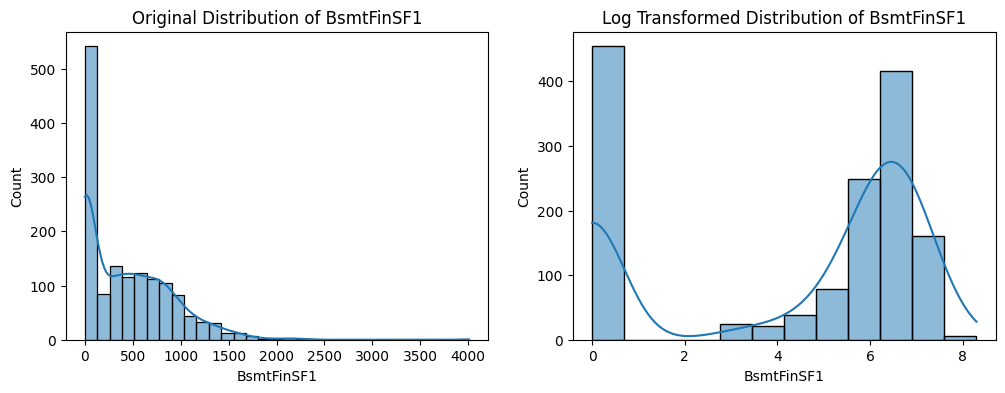

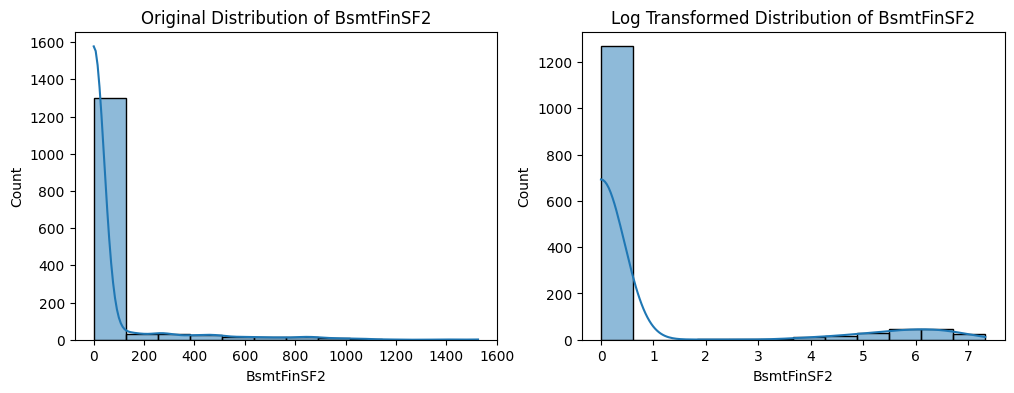

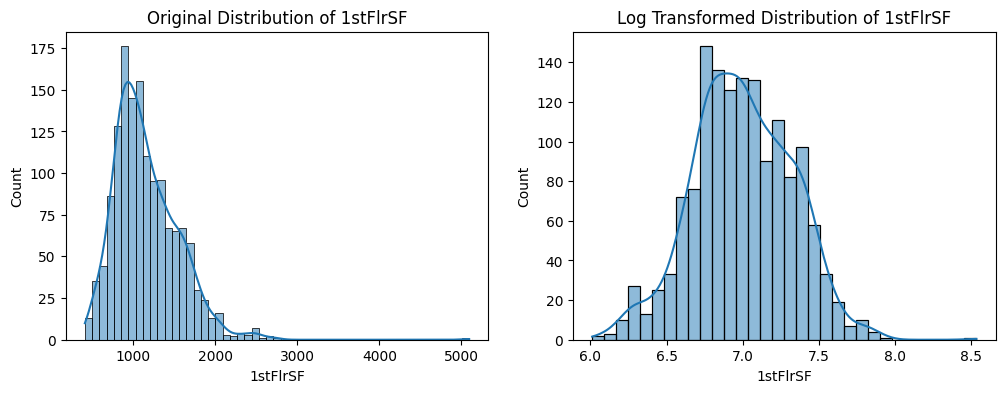

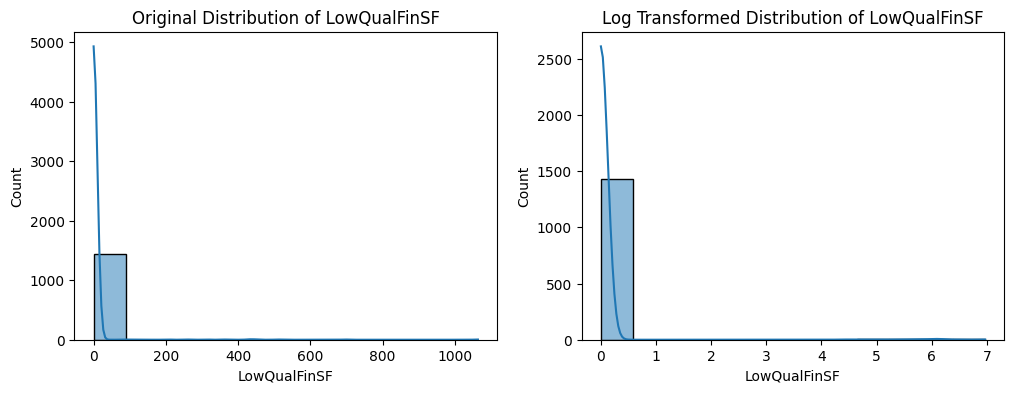

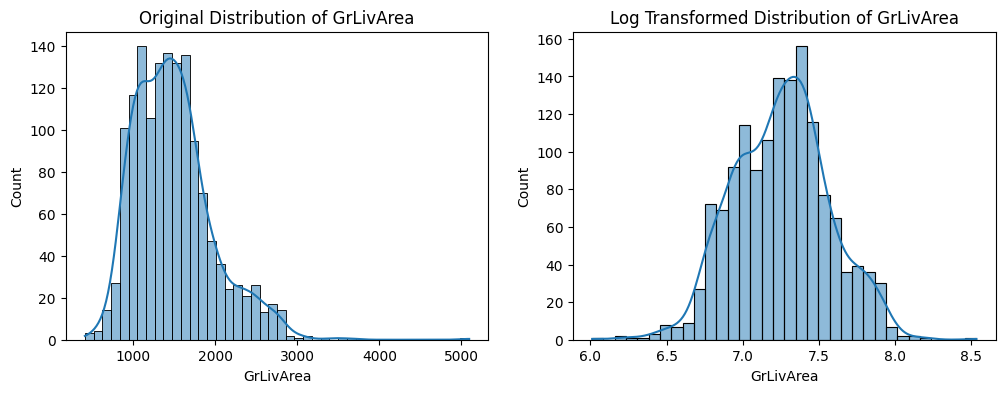

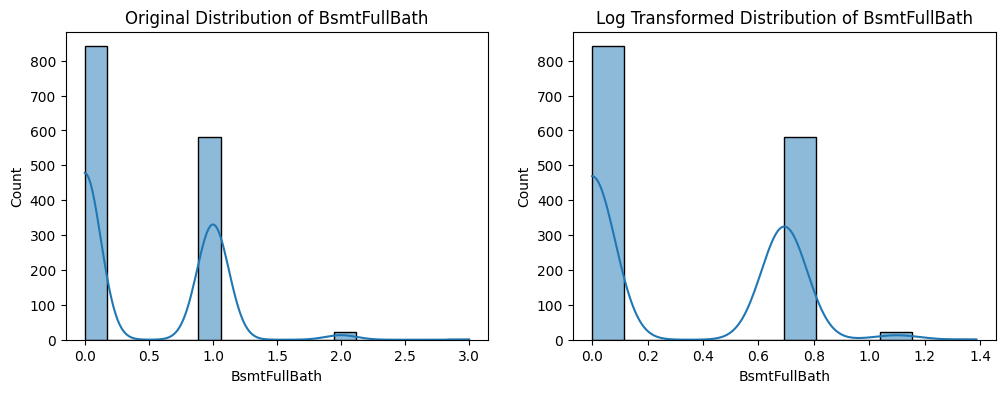

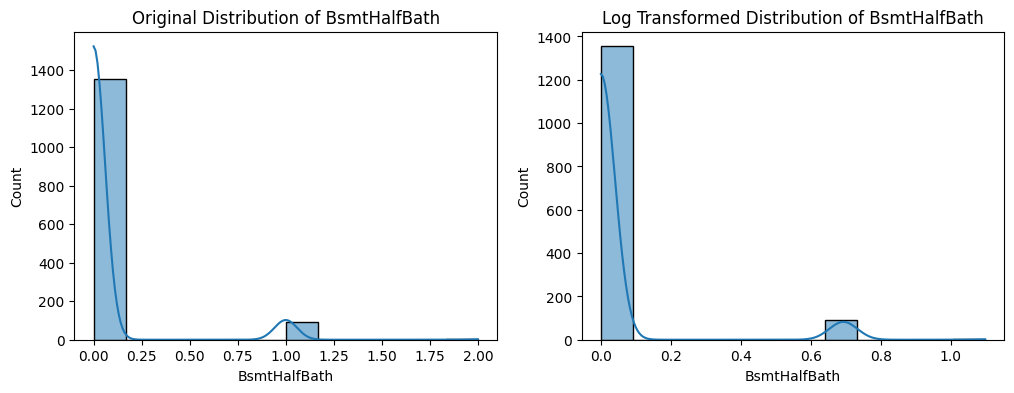

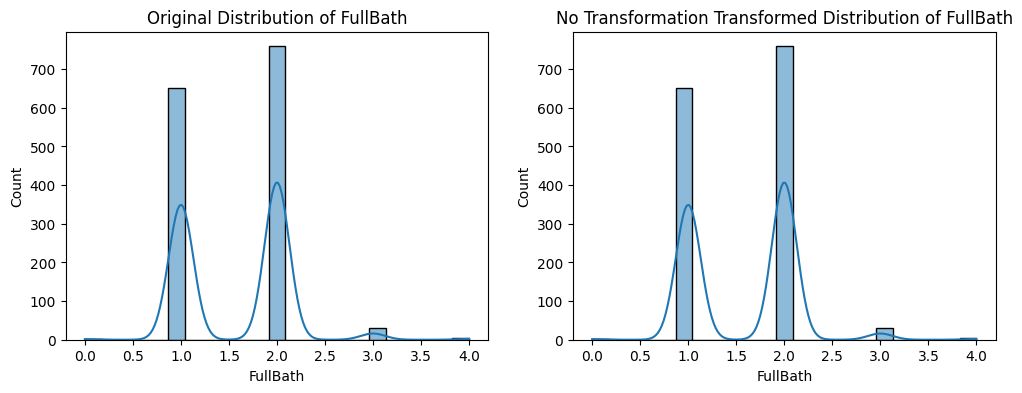

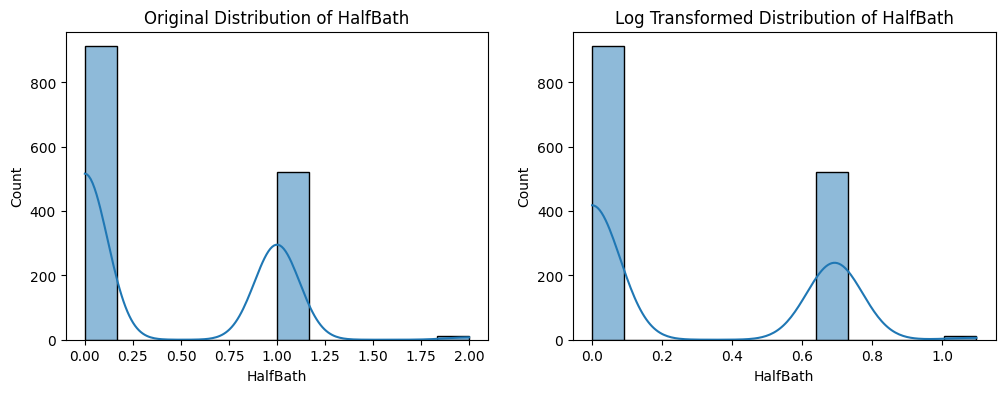

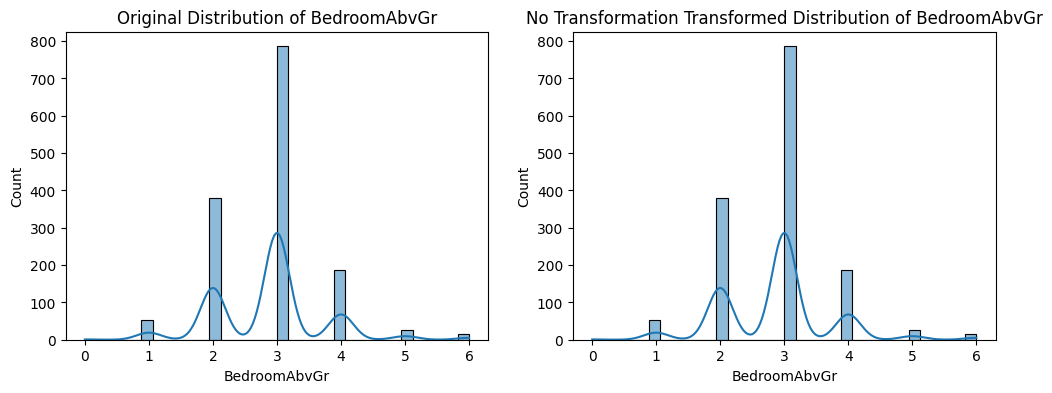

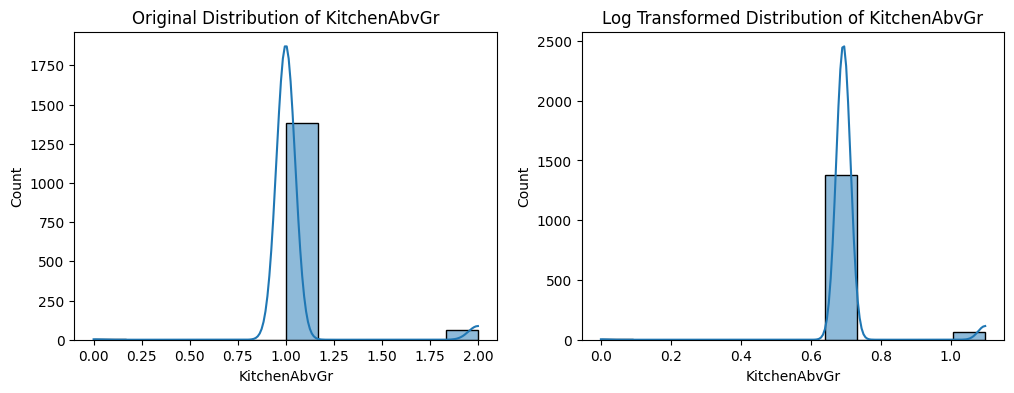

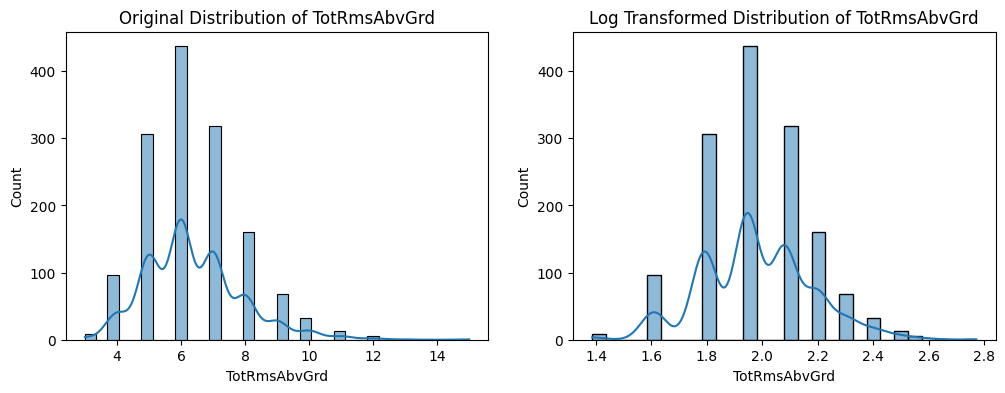

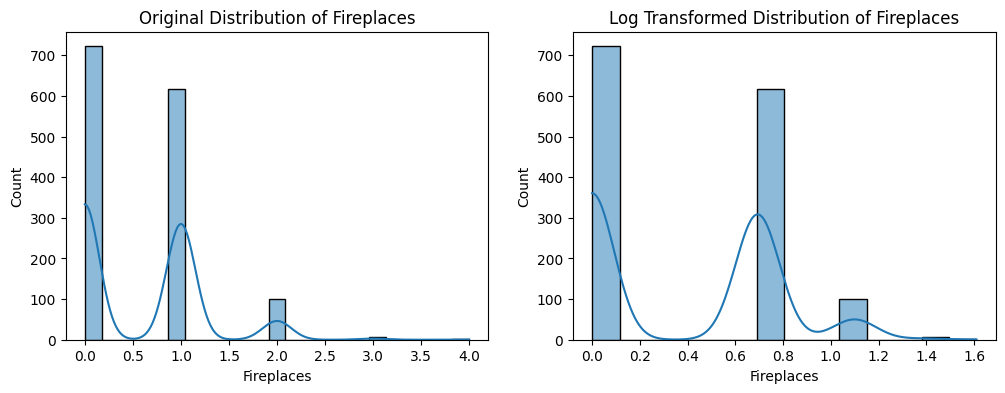

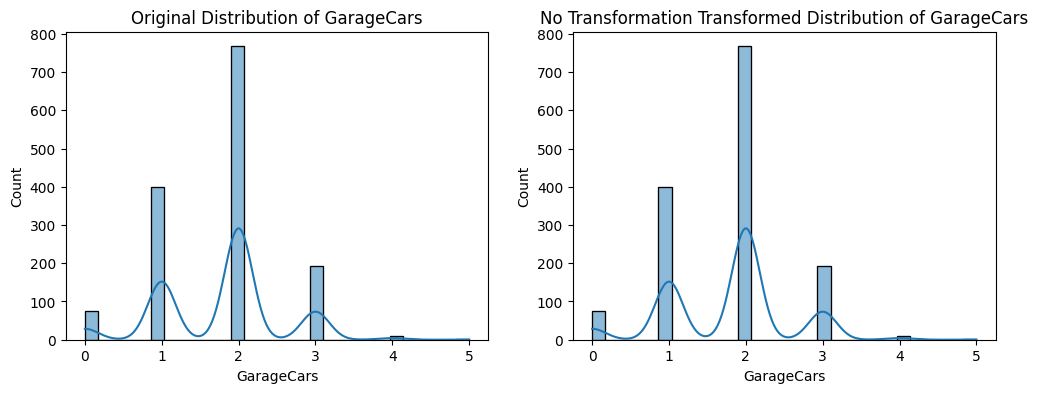

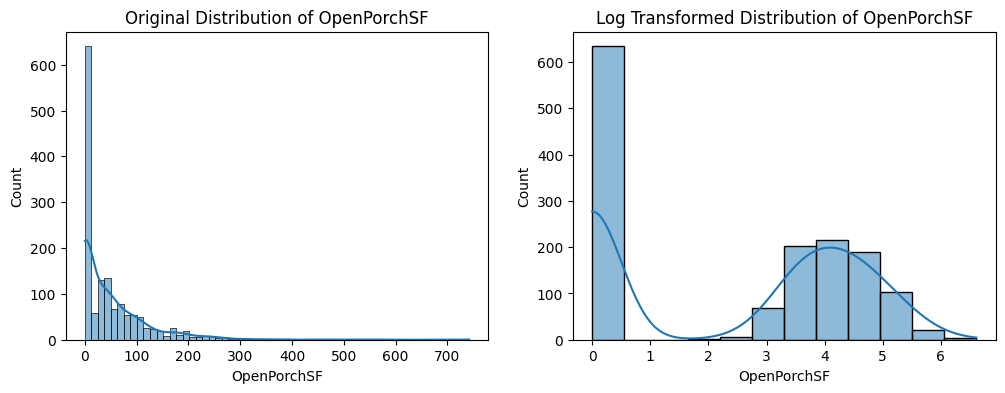

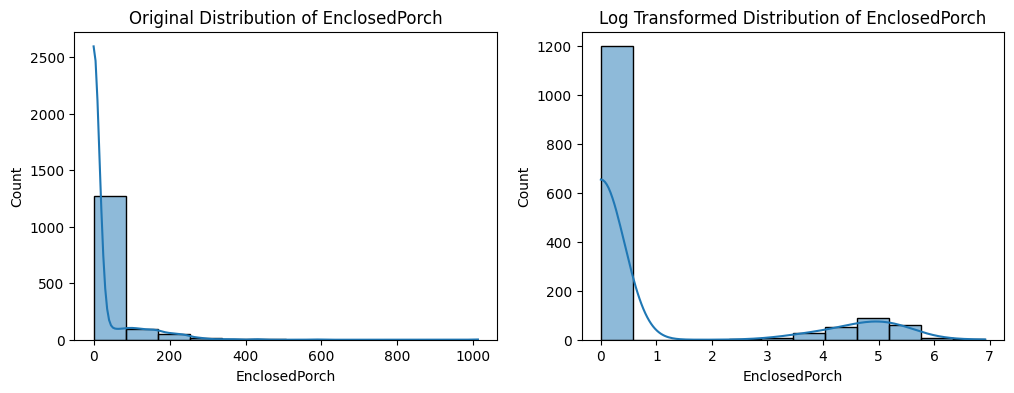

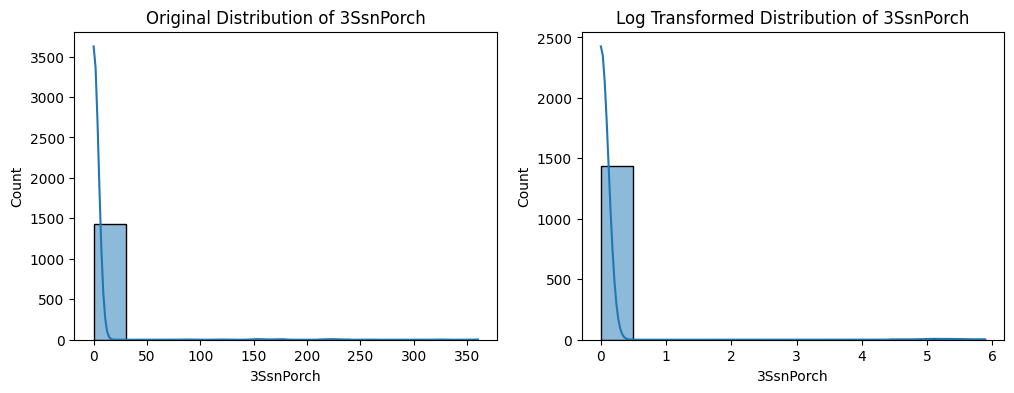

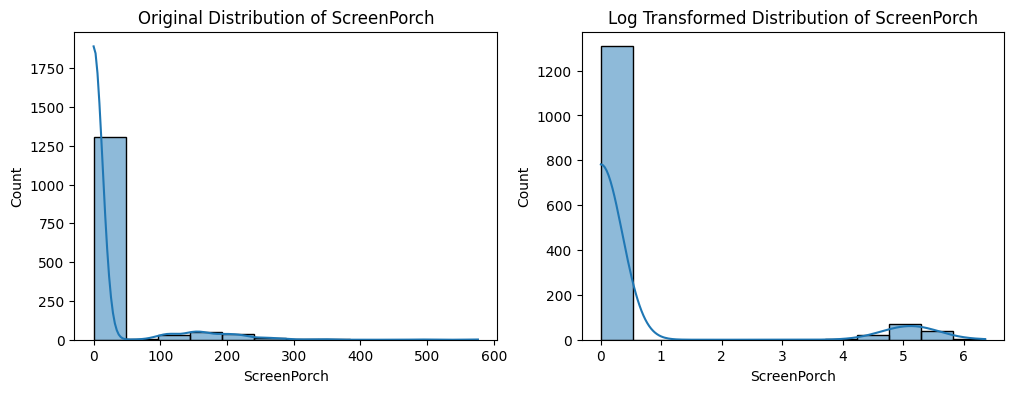

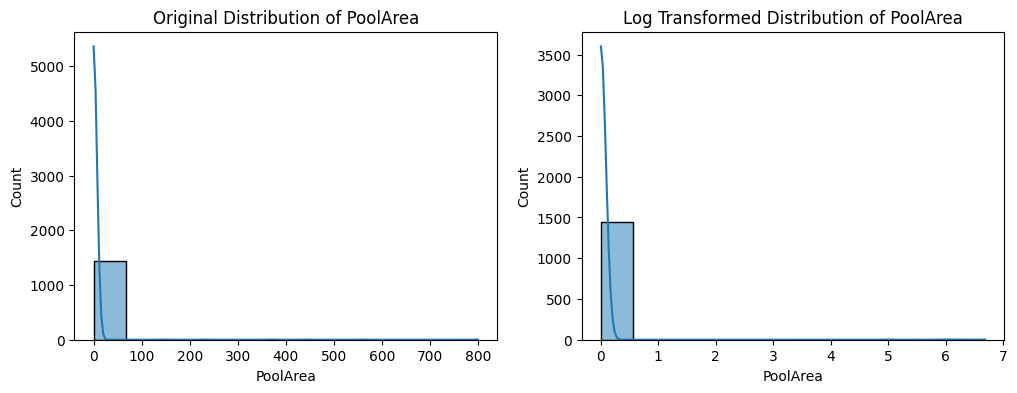

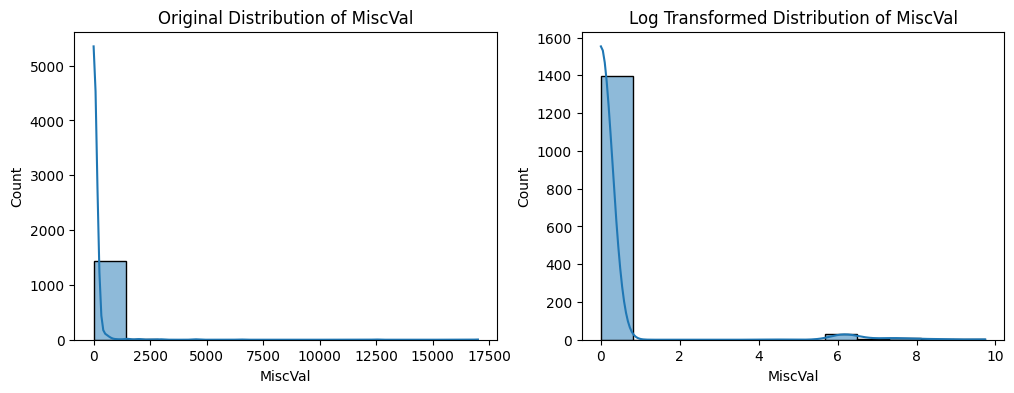

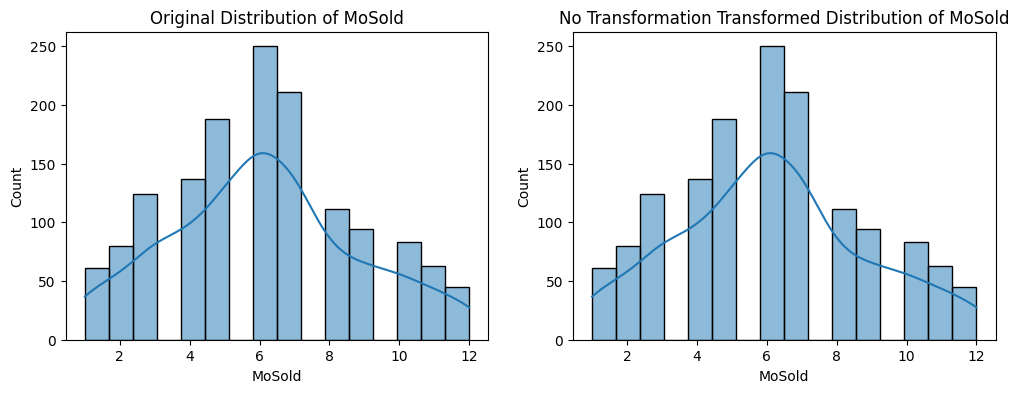

In [53]:
# Log or exponentially transform specific features
numerical_df_transformed, transformation_type = plot_and_transform_skewness_specific_cols(numerical_df, features_to_exclude_from_log_exp_transformation)

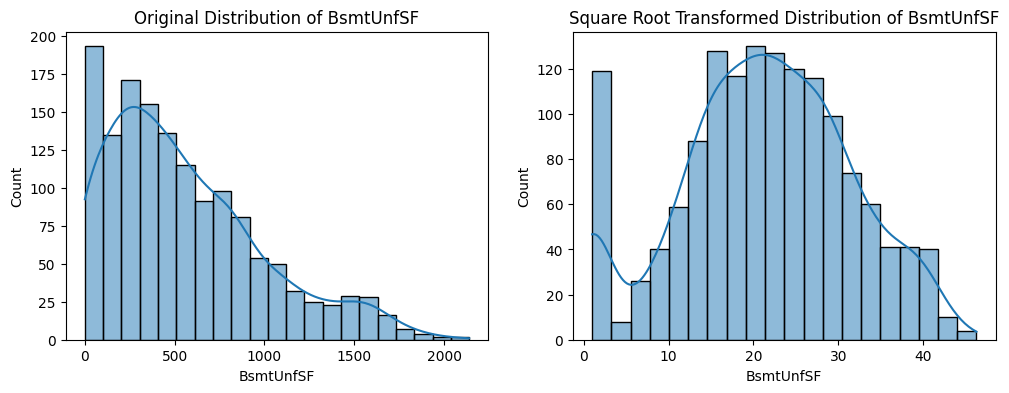

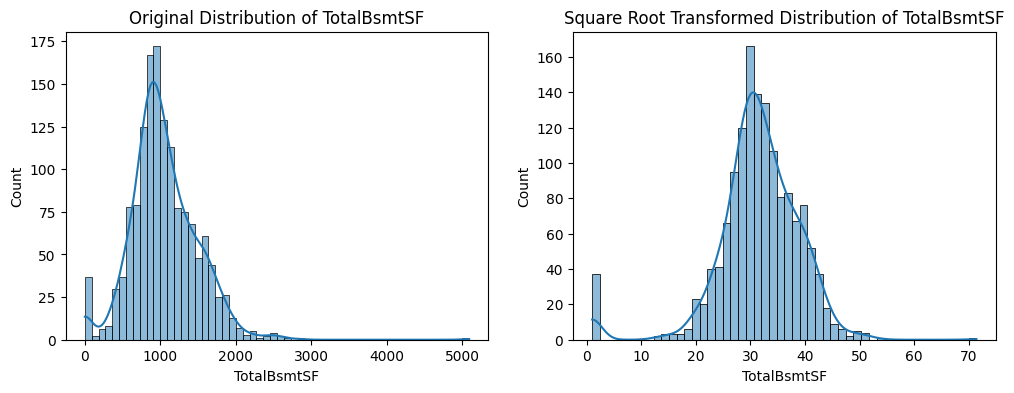

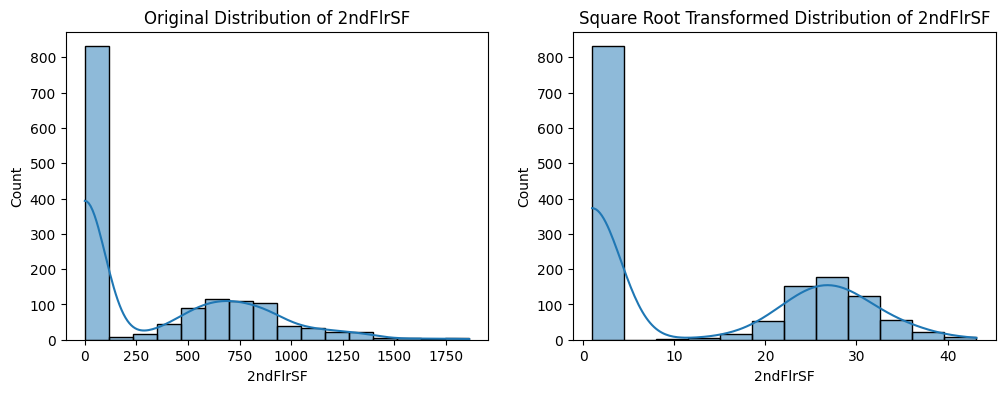

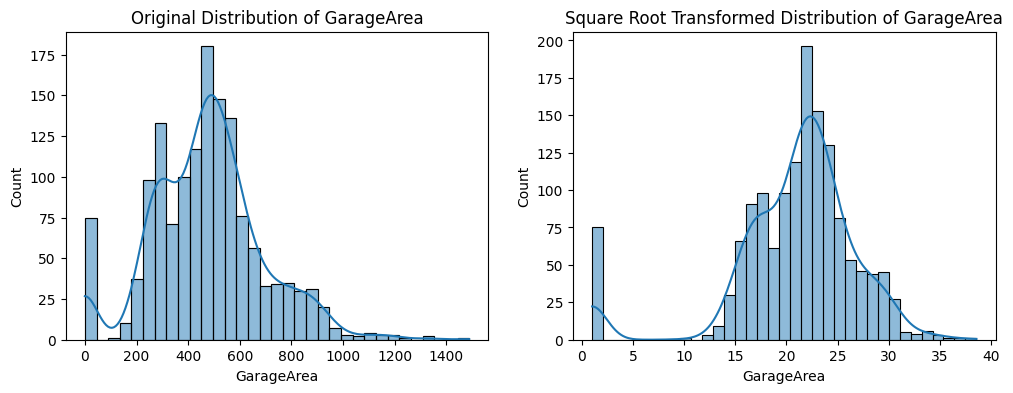

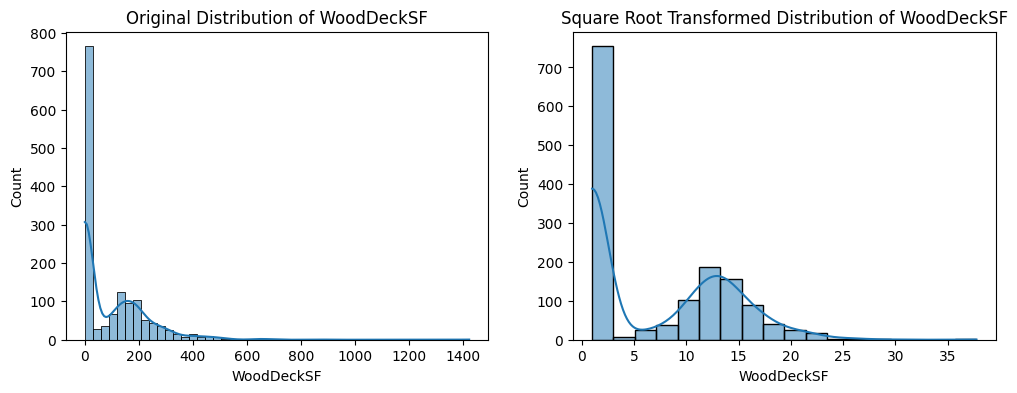

In [54]:
# Perform square root transformation
numerical_df_transformed = plot_square_root_transformation(numerical_df_transformed, features_for_square_root_transformation_list)

#### Normalization

In [64]:
# Scale the numerical features then substitute back into the main dataframe
numerical_df_transformed_scaled, scaler = scale_numerical_features(numerical_df_transformed)

# AttributeError was observed hence it will be managed as below
if isinstance(numerical_df_transformed_scaled, np.ndarray):
    print("Coversion to pd.DataFrame required")
    numerical_df_transformed_scaled = pd.DataFrame(numerical_df_transformed_scaled, columns=numerical_df_transformed.columns, 
                                               index=numerical_df_transformed.index)

df_test_scaled = df_test.copy()

df_test_scaled.loc[:,list(numerical_df_transformed_scaled.columns)] = numerical_df_transformed_scaled

df_test_scaled.head()

Coversion to pd.DataFrame required


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-1.119725,RH,0.630123,0.580831,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,-0.770829,0.398604,-0.352249,-1.083216,Gable,CompShg,VinylSd,VinylSd,None,-0.800927,TA,TA,CBlock,TA,TA,No,Rec,0.643866,LwQ,2.233477,-0.471679,-0.222791,GasA,TA,Y,SBrkr,-0.613766,-0.835163,-0.094487,-1.447321,-0.83923,-0.261101,-1.032774,-0.761165,-1.031520,-0.194119,TA,-0.948480,Typ,-0.962636,No Fireplace,Attchd,-0.696525,Unf,-0.993858,0.991966,TA,TA,Y,0.721406,-1.097849,-0.44831,-0.094968,2.839663,-0.064233,No pool,MnPrv,None,-0.187067,-0.044048,1.711309,WD,Normal
1,-1.119725,RL,0.667739,0.994424,Pave,No alley access,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,-0.067557,0.398604,-0.451374,-1.225743,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,0.989315,TA,TA,CBlock,TA,TA,No,ALQ,0.872673,Unf,-0.370283,-0.107433,0.643698,GasA,TA,Y,SBrkr,0.592565,-0.835163,-0.094487,-0.195987,-0.83923,-0.261101,-1.032774,1.268686,0.176093,-0.194119,Gd,-0.171864,Typ,-0.962636,No Fireplace,Attchd,-0.811268,Unf,-0.993858,-0.517543,TA,TA,Y,1.897588,0.578738,-0.44831,-0.094968,-0.325207,-0.064233,No pool,No fence,Gar2,7.371873,-0.044048,1.711309,WD,Normal
2,0.409713,RL,0.394188,0.931676,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,-0.770829,-0.515469,0.837259,0.674613,Gable,CompShg,VinylSd,VinylSd,None,-0.800927,TA,TA,PConc,Gd,TA,No,GLQ,0.820660,Unf,-0.370283,-0.934299,-0.124749,GasA,Gd,Y,SBrkr,-0.506410,1.068354,-0.094487,0.450210,-0.83923,-0.261101,0.772086,1.268686,0.176093,-0.194119,TA,-0.171864,Typ,0.798748,TA,Attchd,0.680401,Fin,0.295929,0.174676,TA,TA,Y,1.122583,0.552937,-0.44831,-0.094968,-0.325207,-0.064233,No pool,MnPrv,None,-0.187067,-1.149323,1.711309,WD,Normal
3,0.409713,RL,0.553478,0.273202,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,-0.067557,0.398604,0.870301,0.674613,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.360878,TA,TA,PConc,TA,TA,No,GLQ,0.728664,Unf,-0.370283,-0.318051,-0.128961,GasA,Ex,Y,SBrkr,-0.513011,1.035678,-0.094487,0.401106,-0.83923,-0.261101,0.772086,1.268686,0.176093,-0.194119,Gd,0.500870,Typ,0.798748,Gd,Attchd,0.718649,Fin,0.295929,0.130300,TA,TA,Y,1.772312,0.578738,-0.44831,-0.094968,-0.325207,-0.064233,No pool,No fence,None,-0.187067,-0.044048,1.711309,WD,Normal
4,1.392070,RL,-1.240711,-1.118354,Pave,No alley access,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,1.338987,-0.515469,0.672049,0.389560,Gable,CompShg,HdBoard,HdBoard,None,-0.800927,Gd,TA,PConc,Gd,TA,No,ALQ,0.449968,Unf,-0.370283,1.043722,0.556700,GasA,Ex,Y,SBrkr,0.477597,-0.835163,-0.094487,-0.315243,-0.83923,-0.261101,0.772086,-0.761165,-1.031520,-0.194119,Gd,-0.948480,Typ,-0.962636,No Fireplace,Attchd,0.489161,RFn,0.295929,0.261804,TA,TA,Y,-0.882362,0.953865,-0.44831,-0.094968,2.959072,-0.064233,No pool,No fence,None,-0.187067,-1.886174,1.711309,WD,Normal


#### Handling Categorical Data

In [65]:
# One hot encode the categorical features
df_test_scaled_transformed = one_hot_encode_dataframe(df_test_scaled)

C:\Users\chame\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [66]:
# Verify encoding has worked
print(df_test_scaled.shape)
print(df_test_scaled_transformed.shape)

(1447, 79)
(1447, 240)


In [67]:
# Check if all features are numerical
df_test_scaled_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Columns: 240 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(240)
memory usage: 2.6 MB


### 3. Predictions

##### Load Models

In [82]:
prefix = "2024_01_10"
model_path = project_path+"/data/models/"
Lasso_model = pickle.load(open(model_path+prefix+"_Lasso", "rb"))

Ridge_model = pickle.load(open(model_path+prefix+"_Ridge", "rb"))

XGBR_model = pickle.load(open(model_path+prefix+"_XGBR", "rb"))

#### Lasso Predictions

In [83]:
# Subset the dataset for this model
'''
NOTE: The list of features below were not identified in the unseen data and are valid feature values, therefore the columns will be 
generated and zero values inserted
not_in_test_data = ['RoofMatl_CompShg', 'GarageQual_Fa']
'''
# Create a copy of the main test df
lasso_input_df = df_test_scaled_transformed.copy()

lasso_input_df['RoofMatl_CompShg']=0.0
lasso_input_df['GarageQual_Fa']=0.0

lasso_input_df = lasso_input_df[Lasso_Features_list]

In [84]:
# Generate predictions
y_pred_Lasso = Lasso_model.predict(lasso_input_df)

y_pred_Lasso

array([-1.04584294, -0.23970366,  0.14628267, ...,  0.01076885,
       -0.96748625,  0.4914521 ])

#### Ridge Predictions

In [85]:
# Subset the dataset for this model
'''
NOTE: The list of features below were not identified in the unseen data and are valid feature values, therefore the columns will be 
generated and zero values inserted
not_in_test_data_Ridge = ['Exterior1st_Stone', 'GarageQual_Fa', 'HouseStyle_2.5Fin', 'RoofMatl_CompShg', 'RoofMatl_Roll',
'Exterior1st_CBlock', 'Heating_GasA', 'Heating_OthW', 'Electrical_Mix', 'MiscFeature_TenC', 'PoolQC_Fa', 'Condition2_RRAe',
'Condition2_RRAn', 'Condition2_RRNn']

'''
# Create a copy of the main test df
ridge_input_df = df_test_scaled_transformed.copy()

# As per the note above, insert zero values for features that are not used in the Ridge model
not_in_test_data_Ridge = ['Exterior1st_Stone', 'GarageQual_Fa', 'HouseStyle_2.5Fin', 'RoofMatl_CompShg', 'RoofMatl_Roll',
'Exterior1st_CBlock', 'Heating_GasA', 'Heating_OthW', 'Electrical_Mix', 'MiscFeature_TenC', 'PoolQC_Fa', 'Condition2_RRAe',
'Condition2_RRAn', 'Condition2_RRNn']

for item in not_in_test_data_Ridge:
    ridge_input_df[item]=0.0

ridge_input_df = ridge_input_df[Ridge_Features_list]

In [86]:
# Generate predictions
y_pred_Ridge = Ridge_model.predict(ridge_input_df)

y_pred_Ridge

array([-1.58991079, -0.64446513, -0.33674895, ..., -0.48465725,
       -1.52627127, -0.11579957])

#### XGBR Predictions

In [87]:
# Subset the dataset for this model
'''
NOTE: The features identified by recursive feature elimination were also found in the unseen dataset - no action is required. 
'''
# Create a copy of the main test df
xgbr_input_df = df_test_scaled_transformed.copy()

xgbr_input_df = xgbr_input_df[XGBR_Features_list]

In [88]:
# Generate predictions
y_pred_XGBR = XGBR_model.predict(xgbr_input_df)

y_pred_XGBR

array([-0.62636393, -0.06168198,  0.27108765, ..., -0.24943024,
       -0.889349  ,  0.91562873], dtype=float32)

### 4. Inverse Transformation

In [89]:
def reverse_transformation(y_pred, scaler_object, model_name):
    """
    Reverse the transformations applied to the target variable predictions.

    Parameters:
    y_pred (list): Predicted values from the model, expected in the transformed scale.
    scaler_object (scaler): The scaler object used for the initial transformation.
    model_name (str): Name of the model used for predictions.

    Returns:
    ndarray: Transformed predictions back to their original scale.
    """
    # Reverse the scaling performed on the target label
    target_label_scaling_inversed = scaler_object.inverse_transform( np.array(y_pred).reshape(-1, 1))

    # Reverse the Log transformation
    target_label = np.exp(target_label_scaling_inversed)
    
    print(f"The predicted average house price from {model_name} is ${round((target_label.mean()),2)}")
    return target_label

In [90]:
# Import scaler used in the test dataset
with open(project_path+'/data/inverse_transformation/test_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

In [91]:
# Generate the SalePrice for each model
Lasso_target_label = reverse_transformation(y_pred_Lasso, loaded_scaler, "Lasso")
Ridge_target_label = reverse_transformation(y_pred_Ridge, loaded_scaler, "Ridge")
XGBR_target_label = reverse_transformation(y_pred_XGBR, loaded_scaler, "XGBR")

The predicted average house price from Lasso is $169094.23
The predicted average house price from Ridge is $140789.91
The predicted average house price from XGBR is $179338.234375


### Conclusion:
- The mean SalePrice in the test dataset is $180,921 which could suggest, on face value, that the XGBR has performed better than the other models. However, this assessment is misleading as the actual sale price figures of the unseen data are not available. The average sale price in the unseen data could be lower than the average observed in the training dataset.
- If multiple submissions are permitted all the outputs will be submitted to the Kaggle competition to determine the accuracy of each model's predictions. Otherwise based on model performance the Lasso predictions will be submitted. 

### Next Steps:
- Remove outliers prior to data transformation (scaling and log or expontential transformation) and assess impact on model performance
- Incorporate feature engineering
- Explore other regression ML algorithms
- Explore other techniques for managing missing values
- Consider alternative algorithms to further reduce dimensionality such as PCA

The journey of identifying the most effective model is both intricate and iterative. There are occasions where simplicity outperforms complexity, and vice versa. Embrace and enjoy this dynamic and rewarding process.